# HydroLearn Teaching Quickstart
# HydroLearn 教学快速入门

This notebook demonstrates two key hydrological models:
1. **HBV Model** - Continuous rainfall-runoff model for cold/temperate regions
2. **SCS-CN + Unit Hydrograph** - Event-based model for storm runoff analysis

本笔记本演示两个关键水文模型：
1. **HBV模型** - 适用于寒冷/温带地区的连续降雨径流模型
2. **SCS-CN + 单位线** - 用于暴雨径流分析的事件型模型

## Setup and Data Loading
## 设置和数据加载

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

# Add parent directory to path to import models
# 将父目录添加到路径以导入模型
sys.path.insert(0, os.path.abspath('..'))

from hbv_model import HBVModel
from event_model_scs_uh import EventModel

# Set random seed for reproducibility / 设置随机种子以确保可重复性
np.random.seed(42)

print("✓ Modules imported successfully / 模块导入成功")

✓ Modules imported successfully / 模块导入成功


In [3]:
# Load the teaching dataset / 加载教学数据集
data_path = '../data/example_teaching_dataset.csv'
df = pd.read_csv(data_path, parse_dates=['Date'])

print("Dataset Overview / 数据集概览:")
print(f"  Period: {df['Date'].min()} to {df['Date'].max()}")
print(f"  Number of days: {len(df)}")
print(f"\nFirst few rows / 前几行:")
print(df.head())
print(f"\nData statistics / 数据统计:")
print(df.describe())

Dataset Overview / 数据集概览:
  Period: 2020-01-01 00:00:00 to 2020-04-07 00:00:00
  Number of days: 98

First few rows / 前几行:
        Date  Precip  Temp  PET  Observed_Flow
0 2020-01-01     5.2   2.3  0.8           12.5
1 2020-01-02    12.8   1.8  0.7           18.3
2 2020-01-03     8.4   0.5  0.6           25.4
3 2020-01-04     2.1  -1.2  0.5           32.1
4 2020-01-05     0.0  -2.5  0.4           28.7

Data statistics / 数据统计:
                      Date     Precip       Temp        PET  Observed_Flow
count                   98  98.000000  98.000000  98.000000      98.000000
mean   2020-02-18 12:00:00   5.523469   2.144898   0.875510      45.322449
min    2020-01-01 00:00:00   0.000000  -4.200000   0.300000      12.500000
25%    2020-01-25 06:00:00   0.000000  -0.375000   0.500000      32.600000
50%    2020-02-18 12:00:00   3.700000   2.550000   0.850000      45.250000
75%    2020-03-13 18:00:00   9.275000   4.700000   1.200000      56.275000
max    2020-04-07 00:00:00  22.400000   7.900

## Part 1: HBV Model Demonstration
## 第一部分：HBV模型演示

The HBV model is a conceptual rainfall-runoff model that accounts for:
- Snow accumulation and melt (degree-day method)
- Soil moisture dynamics
- Three-component runoff generation (fast, interflow, baseflow)

HBV模型是一个概念性降雨径流模型，考虑：
- 积雪累积和融化（度日法）
- 土壤水分动态
- 三成分径流产生（快速流、壤中流、基流）

In [4]:
# Extract data for HBV model / 提取HBV模型数据
P = df['Precip'].values  # Precipitation / 降水
T = df['Temp'].values    # Temperature / 温度
PET = df['PET'].values   # Potential Evapotranspiration / 潜在蒸散发
Q_obs = df['Observed_Flow'].values  # Observed flow / 观测流量

print("Input Data Summary / 输入数据摘要:")
print(f"  Mean Precipitation / 平均降水: {np.mean(P):.2f} mm/day")
print(f"  Mean Temperature / 平均温度: {np.mean(T):.2f} °C")
print(f"  Mean PET / 平均潜在蒸散发: {np.mean(PET):.2f} mm/day")
print(f"  Mean Observed Flow / 平均观测流量: {np.mean(Q_obs):.2f} mm/day")

Input Data Summary / 输入数据摘要:
  Mean Precipitation / 平均降水: 5.52 mm/day
  Mean Temperature / 平均温度: 2.14 °C
  Mean PET / 平均潜在蒸散发: 0.88 mm/day
  Mean Observed Flow / 平均观测流量: 45.32 mm/day


In [6]:
# Initialize HBV model with default parameters / 使用默认参数初始化HBV模型
hbv = HBVModel()

print("HBV Model Parameters / HBV模型参数:")
print(f"  Snow threshold temperature (TT) / 降雪阈值温度: {hbv.TT} °C")
print(f"  Degree-day factor (CFMAX) / 度日因子: {hbv.CFMAX} mm/°C/day")
print(f"  Field capacity (FC) / 田间持水量: {hbv.FC} mm")
print(f"  Soil parameter (BETA) / 土壤参数: {hbv.BETA}")
print(f"  Quick runoff coefficient (K0) / 快速径流系数: {hbv.K0} 1/day")
print(f"  Interflow coefficient (K1) / 壤中流系数: {hbv.K1} 1/day")
print(f"  Baseflow coefficient (K2) / 基流系数: {hbv.K2} 1/day")

HBV Model Parameters / HBV模型参数:
  Snow threshold temperature (TT) / 降雪阈值温度: 0.0 °C
  Degree-day factor (CFMAX) / 度日因子: 3.5 mm/°C/day
  Field capacity (FC) / 田间持水量: 200.0 mm
  Soil parameter (BETA) / 土壤参数: 2.0
  Quick runoff coefficient (K0) / 快速径流系数: 0.2 1/day
  Interflow coefficient (K1) / 壤中流系数: 0.1 1/day
  Baseflow coefficient (K2) / 基流系数: 0.05 1/day


In [7]:
# Run HBV model / 运行HBV模型
results_hbv = hbv.run(P, T, PET)

print("\nHBV Model Results / HBV模型结果:")
print(f"  Total discharge / 总径流: {np.sum(results_hbv['Q']):.2f} mm")
print(f"  Total actual ET / 总实际蒸散发: {np.sum(results_hbv['EA']):.2f} mm")
print(f"  Final snowpack / 最终积雪: {results_hbv['SP'][-1]:.2f} mm")
print(f"  Final soil moisture / 最终土壤水: {results_hbv['SM'][-1]:.2f} mm")
print(f"  Runoff coefficient / 径流系数: {np.sum(results_hbv['Q'])/np.sum(P):.3f}")

# Calculate Nash-Sutcliffe Efficiency / 计算纳什效率系数
nse = 1 - np.sum((Q_obs - results_hbv['Q'])**2) / np.sum((Q_obs - np.mean(Q_obs))**2)
print(f"  Nash-Sutcliffe Efficiency / 纳什效率系数: {nse:.3f}")


HBV Model Results / HBV模型结果:
  Total discharge / 总径流: 389.74 mm
  Total actual ET / 总实际蒸散发: 84.72 mm
  Final snowpack / 最终积雪: 0.00 mm
  Final soil moisture / 最终土壤水: 165.21 mm
  Runoff coefficient / 径流系数: 0.720
  Nash-Sutcliffe Efficiency / 纳什效率系数: -6.967


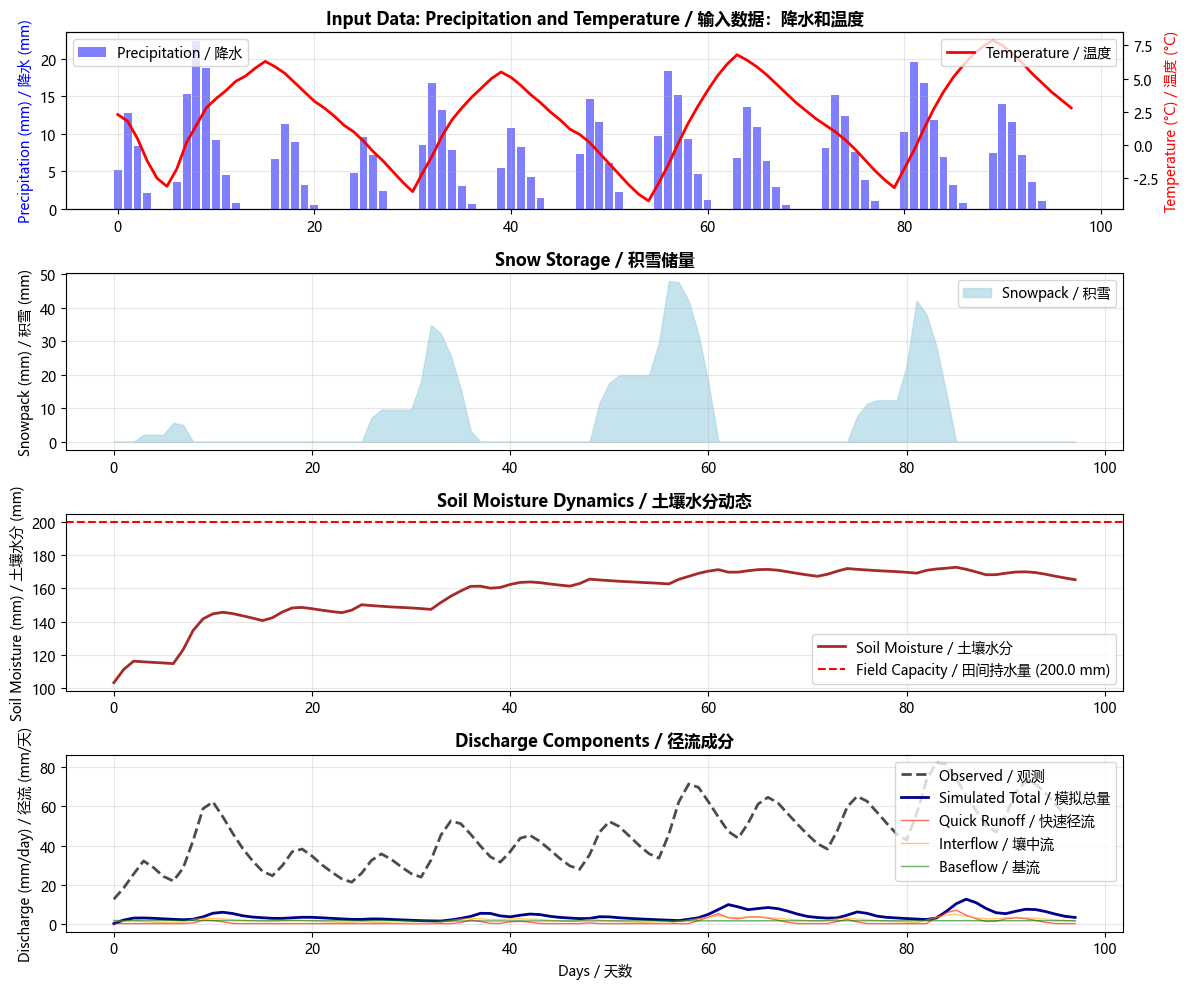


✓ HBV visualization saved to figures/teaching_hbv_demo.png
✓ HBV可视化已保存到 figures/teaching_hbv_demo.png


In [8]:
# Visualize HBV results / 可视化HBV结果
fig, axes = plt.subplots(4, 1, figsize=(12, 10))
days = np.arange(len(P))

# Precipitation and Temperature / 降水和温度
ax1 = axes[0]
ax1_twin = ax1.twinx()
ax1.bar(days, P, color='blue', alpha=0.5, label='Precipitation / 降水')
ax1_twin.plot(days, T, color='red', linewidth=2, label='Temperature / 温度')
ax1.set_ylabel('Precipitation (mm) / 降水 (mm)', color='blue')
ax1_twin.set_ylabel('Temperature (°C) / 温度 (°C)', color='red')
ax1.set_title('Input Data: Precipitation and Temperature / 输入数据：降水和温度', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Snowpack / 积雪
axes[1].fill_between(days, 0, results_hbv['SP'], color='lightblue', alpha=0.7, label='Snowpack / 积雪')
axes[1].set_ylabel('Snowpack (mm) / 积雪 (mm)')
axes[1].set_title('Snow Storage / 积雪储量', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Soil Moisture / 土壤水分
axes[2].plot(days, results_hbv['SM'], color='brown', linewidth=2, label='Soil Moisture / 土壤水分')
axes[2].axhline(y=hbv.FC, color='red', linestyle='--', label=f'Field Capacity / 田间持水量 ({hbv.FC} mm)')
axes[2].set_ylabel('Soil Moisture (mm) / 土壤水分 (mm)')
axes[2].set_title('Soil Moisture Dynamics / 土壤水分动态', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Discharge / 径流
axes[3].plot(days, Q_obs, color='black', linewidth=2, linestyle='--', label='Observed / 观测', alpha=0.7)
axes[3].plot(days, results_hbv['Q'], color='darkblue', linewidth=2, label='Simulated Total / 模拟总量')
axes[3].plot(days, results_hbv['Q0'], color='red', linewidth=1, alpha=0.6, label='Quick Runoff / 快速径流')
axes[3].plot(days, results_hbv['Q1'], color='orange', linewidth=1, alpha=0.6, label='Interflow / 壤中流')
axes[3].plot(days, results_hbv['Q2'], color='green', linewidth=1, alpha=0.6, label='Baseflow / 基流')
axes[3].set_xlabel('Days / 天数')
axes[3].set_ylabel('Discharge (mm/day) / 径流 (mm/天)')
axes[3].set_title('Discharge Components / 径流成分', fontsize=12, fontweight='bold')
axes[3].legend(loc='upper right')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/teaching_hbv_demo.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ HBV visualization saved to figures/teaching_hbv_demo.png")
print("✓ HBV可视化已保存到 figures/teaching_hbv_demo.png")

## Part 2: SCS-CN + Unit Hydrograph Demonstration
## 第二部分：SCS-CN + 单位线演示

The SCS Curve Number method combined with Unit Hydrograph routing is widely used for:
- Design storm analysis
- Urban drainage planning
- Land use impact assessment

SCS曲线数法结合单位线汇流广泛用于：
- 设计暴雨分析
- 城市排水规划
- 土地利用影响评估

In [9]:
# Select a storm event from the dataset / 从数据集中选择一个暴雨事件
# We'll use the first major storm (days 7-12) / 我们将使用第一次大暴雨（第7-12天）
storm_start = 7
storm_duration = 6
P_event = df['Precip'].values[storm_start:storm_start+storm_duration]
dt = 1.0  # Daily time step / 日时间步长

print("Storm Event Data / 暴雨事件数据:")
print(f"  Duration / 持续时间: {storm_duration} days")
print(f"  Total precipitation / 总降水量: {np.sum(P_event):.2f} mm")
print(f"  Peak precipitation / 峰值降水: {np.max(P_event):.2f} mm/day")
print(f"  Storm pattern / 暴雨模式: {P_event}")

Storm Event Data / 暴雨事件数据:
  Duration / 持续时间: 6 days
  Total precipitation / 总降水量: 70.90 mm
  Peak precipitation / 峰值降水: 22.40 mm/day
  Storm pattern / 暴雨模式: [15.3 22.4 18.7  9.2  4.5  0.8]


In [10]:
# Initialize SCS-CN + UH model / 初始化SCS-CN + UH模型
# CN=70 represents typical agricultural land / CN=70代表典型农田
scs_model = EventModel(CN=70, Tp=2.0, dt=dt)

print("SCS Model Parameters / SCS模型参数:")
print(f"  Curve Number (CN) / 曲线数: {scs_model.CN}")
print(f"  Maximum retention (S) / 最大截留量: {scs_model.scs.S:.2f} mm")
print(f"  Initial abstraction (Ia) / 初损: {scs_model.scs.Ia:.2f} mm")
print(f"  Time to peak (Tp) / 峰现时间: {scs_model.Tp} hours")
if scs_model.uh_type == 'triangular':
    print(f"  Base time (Tb) / 基础时间: {2.67 * scs_model.Tp:.2f} hours")
print(f"  Time step (dt) / 时间步长: {scs_model.dt} hours")

SCS Model Parameters / SCS模型参数:
  Curve Number (CN) / 曲线数: 70
  Maximum retention (S) / 最大截留量: 108.86 mm
  Initial abstraction (Ia) / 初损: 21.77 mm
  Time to peak (Tp) / 峰现时间: 2.0 hours
  Base time (Tb) / 基础时间: 5.34 hours
  Time step (dt) / 时间步长: 1.0 hours


In [11]:
# Run SCS-CN + UH model / 运行SCS-CN + UH模型
results_scs = scs_model.run(P_event)

# Calculate summary statistics
total_runoff = np.sum(results_scs['Q_direct'])
peak_discharge = np.max(results_scs['Q_hydrograph'])
time_to_peak = np.argmax(results_scs['Q_hydrograph']) * dt

print("\nSCS Model Results / SCS模型结果:")
print(f"  Total runoff / 总径流: {total_runoff:.2f} mm")
print(f"  Peak discharge / 峰值流量: {peak_discharge:.2f} mm/hour")
print(f"  Time to peak / 峰现时间: {time_to_peak:.1f} hours")
print(f"  Runoff coefficient / 径流系数: {total_runoff/np.sum(P_event):.3f}")


SCS Model Results / SCS模型结果:
  Total runoff / 总径流: 15.28 mm
  Peak discharge / 峰值流量: 3.97 mm/hour
  Time to peak / 峰现时间: 5.0 hours
  Runoff coefficient / 径流系数: 0.215


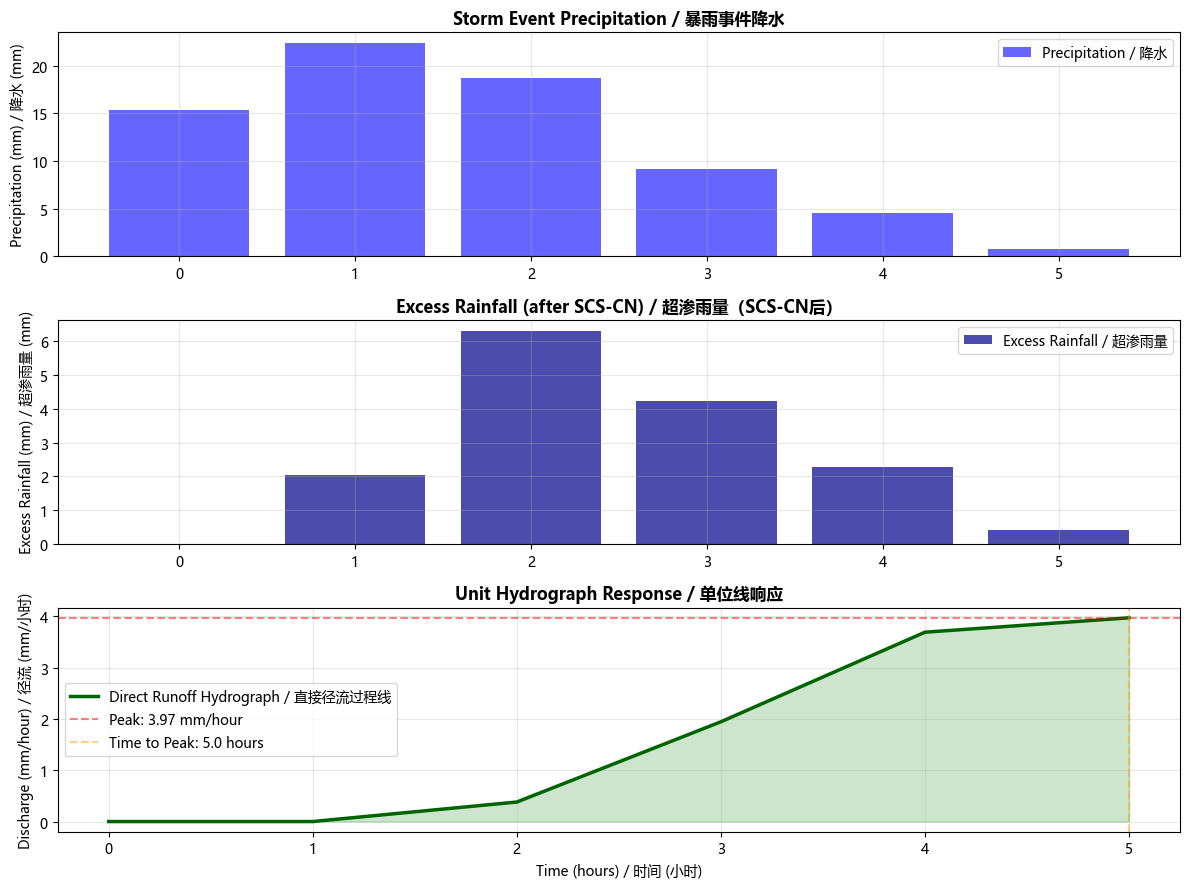


✓ SCS-CN+UH visualization saved to figures/teaching_scs_demo.png
✓ SCS-CN+UH可视化已保存到 figures/teaching_scs_demo.png


In [12]:
# Visualize SCS-CN + UH results / 可视化SCS-CN + UH结果
fig, axes = plt.subplots(3, 1, figsize=(12, 9))
time_event = np.arange(len(P_event)) * dt
time_discharge = np.arange(len(results_scs['Q_hydrograph'])) * dt

# Recalculate summary statistics for plotting
peak_discharge = np.max(results_scs['Q_hydrograph'])
time_to_peak_idx = np.argmax(results_scs['Q_hydrograph'])
time_to_peak = time_to_peak_idx * dt

# Input precipitation / 输入降水
axes[0].bar(time_event, P_event, width=0.8*dt, color='blue', alpha=0.6, label='Precipitation / 降水')
axes[0].set_ylabel('Precipitation (mm) / 降水 (mm)')
axes[0].set_title('Storm Event Precipitation / 暴雨事件降水', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Excess rainfall (effective precipitation) / 超渗雨量（有效降水）
axes[1].bar(time_event, results_scs['Pe'], width=0.8*dt, color='darkblue', alpha=0.7, label='Excess Rainfall / 超渗雨量')
axes[1].set_ylabel('Excess Rainfall (mm) / 超渗雨量 (mm)')
axes[1].set_title('Excess Rainfall (after SCS-CN) / 超渗雨量（SCS-CN后）', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Discharge hydrograph / 径流过程线
axes[2].plot(time_discharge, results_scs['Q_hydrograph'], color='darkgreen', linewidth=2.5, label='Direct Runoff Hydrograph / 直接径流过程线')
axes[2].axhline(y=peak_discharge, color='red', linestyle='--', alpha=0.5, label=f"Peak: {peak_discharge:.2f} mm/hour")
axes[2].axvline(x=time_to_peak, color='orange', linestyle='--', alpha=0.5, label=f"Time to Peak: {time_to_peak:.1f} hours")
axes[2].fill_between(time_discharge, 0, results_scs['Q_hydrograph'], color='green', alpha=0.2)
axes[2].set_xlabel('Time (hours) / 时间 (小时)')
axes[2].set_ylabel('Discharge (mm/hour) / 径流 (mm/小时)')
axes[2].set_title('Unit Hydrograph Response / 单位线响应', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/teaching_scs_demo.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ SCS-CN+UH visualization saved to figures/teaching_scs_demo.png")
print("✓ SCS-CN+UH可视化已保存到 figures/teaching_scs_demo.png")

## Part 3: Comparison of Land Use Scenarios
## 第三部分：土地利用情景比较

Demonstrate how different land uses affect runoff generation.

演示不同土地利用如何影响径流产生。


Land Use Scenario Comparison / 土地利用情景比较:
Scenario / 情景             CN       Total Runoff (mm)    Peak (mm/hour)      
-------------------------------------------------------------------------
Forest / 森林               55       3.63                 1.00                
Agricultural / 农田         70       15.28                3.97                
Residential / 住宅          85       35.93                9.14                
Urban / 城市                95       57.05                14.25               


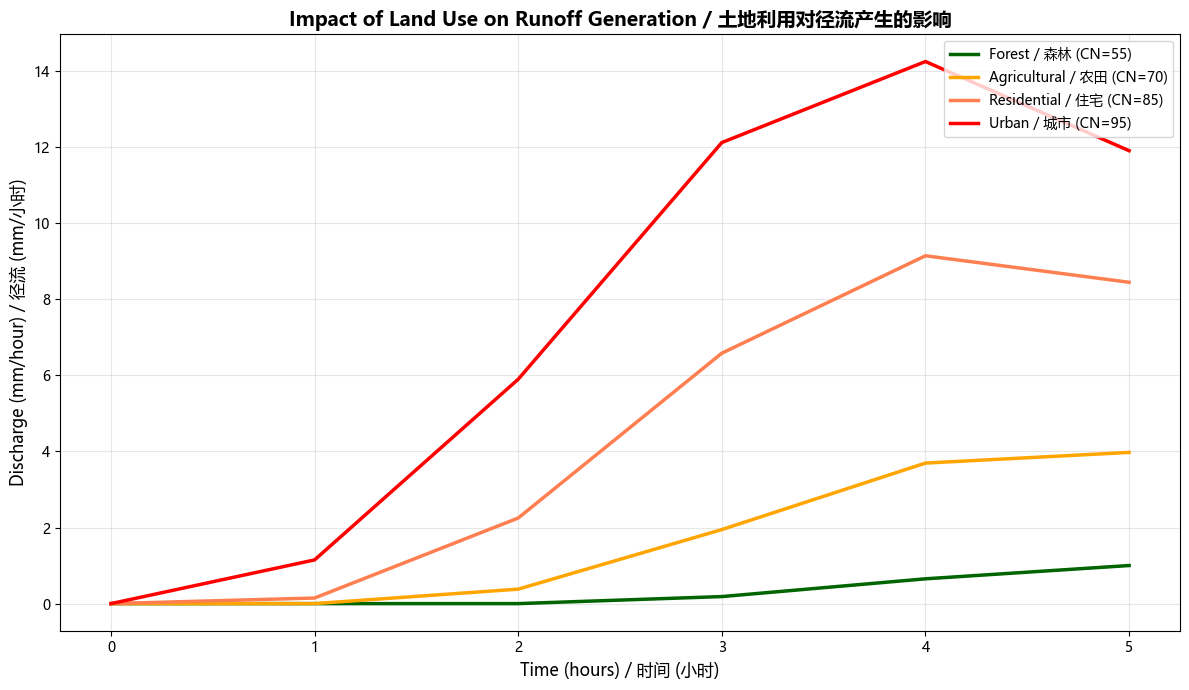


✓ Land use comparison saved to figures/teaching_landuse_comparison.png
✓ 土地利用比较已保存到 figures/teaching_landuse_comparison.png


In [13]:
# Define different land use scenarios / 定义不同土地利用情景
scenarios = [
    {'name': 'Forest / 森林', 'CN': 55, 'color': 'darkgreen'},
    {'name': 'Agricultural / 农田', 'CN': 70, 'color': 'orange'},
    {'name': 'Residential / 住宅', 'CN': 85, 'color': 'coral'},
    {'name': 'Urban / 城市', 'CN': 95, 'color': 'red'}
]

# Run model for each scenario / 为每个情景运行模型
fig, ax = plt.subplots(figsize=(12, 7))

print("\nLand Use Scenario Comparison / 土地利用情景比较:")
print(f"{'Scenario / 情景':<25} {'CN':<8} {'Total Runoff (mm)':<20} {'Peak (mm/hour)':<20}")
print("-" * 73)

for scenario in scenarios:
    model = EventModel(CN=scenario['CN'], Tp=2.0, dt=dt)
    results = model.run(P_event)
    
    total_runoff = np.sum(results['Q_direct'])
    peak_discharge = np.max(results['Q_hydrograph'])
    
    time_discharge = np.arange(len(results['Q_hydrograph'])) * dt
    ax.plot(time_discharge, results['Q_hydrograph'], 
            linewidth=2.5, label=f"{scenario['name']} (CN={scenario['CN']})",
            color=scenario['color'])
    
    print(f"{scenario['name']:<25} {scenario['CN']:<8} {total_runoff:<20.2f} {peak_discharge:<20.2f}")

ax.set_xlabel('Time (hours) / 时间 (小时)', fontsize=12)
ax.set_ylabel('Discharge (mm/hour) / 径流 (mm/小时)', fontsize=12)
ax.set_title('Impact of Land Use on Runoff Generation / 土地利用对径流产生的影响', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/teaching_landuse_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Land use comparison saved to figures/teaching_landuse_comparison.png")
print("✓ 土地利用比较已保存到 figures/teaching_landuse_comparison.png")

## Summary and Key Learning Points
## 总结和关键学习要点

### HBV Model / HBV模型
**Strengths / 优势:**
- Suitable for cold/temperate regions with snow / 适用于有降雪的寒冷/温带地区
- Continuous simulation capability / 连续模拟能力
- Separates runoff components / 分离径流成分

**Best Used For / 最佳用途:**
- Long-term water balance studies / 长期水量平衡研究
- Climate change impact assessment / 气候变化影响评估
- Regions with significant snow processes / 有显著积雪过程的地区

### SCS-CN + UH Model / SCS-CN + UH模型
**Strengths / 优势:**
- Simple and widely used / 简单且广泛使用
- Accounts for land use effects / 考虑土地利用影响
- Good for design storms / 适用于设计暴雨

**Best Used For / 最佳用途:**
- Urban drainage design / 城市排水设计
- Event-based flood analysis / 事件型洪水分析
- Land use change scenarios / 土地利用变化情景

### Educational Value / 教学价值
This notebook demonstrates:
1. Continuous vs. event-based modeling approaches / 连续型与事件型建模方法
2. Impact of temperature on hydrological processes / 温度对水文过程的影响
3. Role of land use in runoff generation / 土地利用在径流产生中的作用
4. Practical application of conceptual models / 概念模型的实际应用